In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotting
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.signal import detrend
%matplotlib inline

In [10]:
from load_dataset import Dataset

In [38]:
dataset = Dataset('../data/dataset/')

In [39]:
# возьмем временной ряд, характеризующий продажи алкоголя по месяцам
ts = dataset["alcohol_sales.csv"]

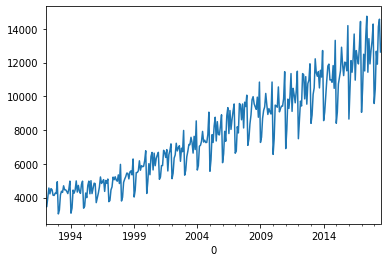

In [40]:
ts.plot()

In [41]:
# как можно заметить, у него есть окололинейный тренд, гетероскедастичность, сезонный период равен 12 (месяцам)

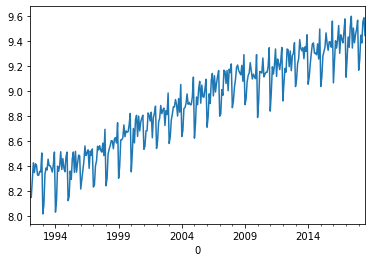

In [42]:
# сначала уберем гетероскедастичность простым логарифмированием
ts_log = np.log(ts)
ts_log.plot()

In [43]:
# Теперь подберем порядки дифференцирования d, D
# d малое подбирается таким образом, что d раз продифференцировав ряд, мы добьемся стационарности
# D большое обычно подбирается так, что если d малое не дало стацинарности, мы можем D раз сезонно придифференцировать
# ряд, пока он не станет стационарным.

In [64]:
# для начала просто продифференцируем один раз

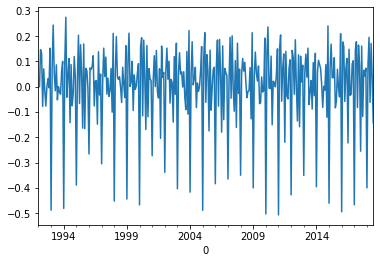

In [124]:
# данный ряд недостаточно стационарен, т.к сохраняет сезонность
ts_log.diff().plot()

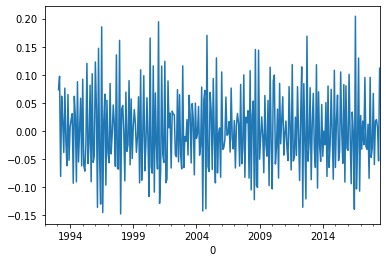

In [125]:
# попробуем применить сезонное дифференцирование 
ts_log.diff().diff(12).plot()

In [126]:
# уже лучше
# посмотрим, что скажет критерий Дики Фуллера
adfuller(ts_log.diff().diff(12).dropna())[1]

6.351881583271299e-12

In [127]:
# отлично, вердикт о стационарности подтвержден, (d, D) = (1, 1)

In [128]:
# теперь разберемся с параметрами q, Q, p, P.
# Для этого сначала уберем тренд, чтобы он не искажал график автокорреляций.

In [129]:
ts_flat = pd.Series(detrend(ts_log), ts_log.index)

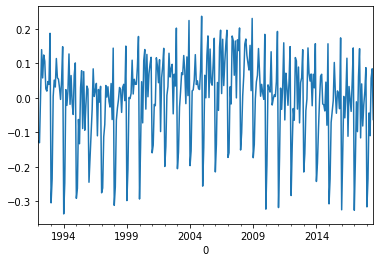

In [130]:
# тут, кстати, мы сразу можем заметить, что помимо сезонности мы имеем цикличность порядка 10 лет длинной 
ts_flat.plot()

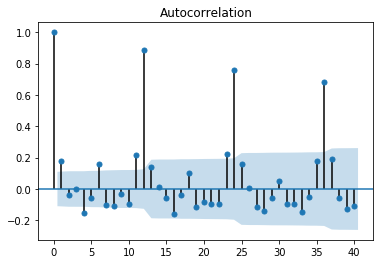

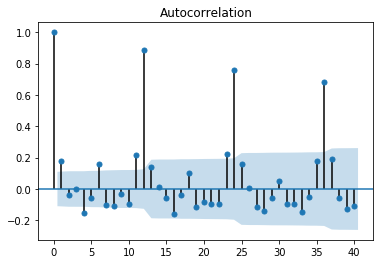

In [131]:
# отлично, для поиска параметров q, Q нарисуем график автокорреляций
# последний значимый несезонный лаг определяется как последний лаг, котоырй еще не пересек
# интервал значимости по модулю (то есть ВСЕ лаги от нулевого до него были выше порога значимости).
# В данном случае он равено одному (не забываем, что считаем мы с нуля - нулевого лага). Итак q = 1
plot_acf(ts_flat, lags=40)

In [132]:
# Теперь разберемся с оценкой для сезонного лага Q. Для этого нарисуем тот же график автокорреляций, но с большим
# горизонтом лагов

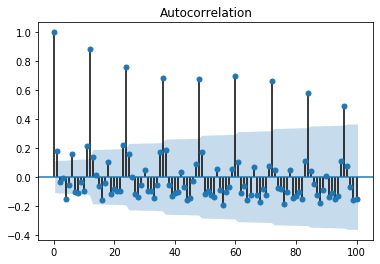

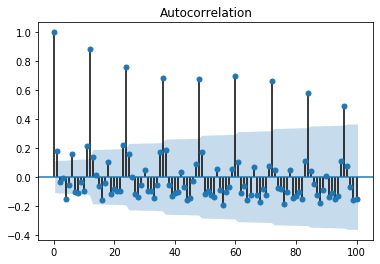

In [133]:
# на данном графике мы видим, что у нас помимо нашей сезонности присутствует квартальная сезонность!
# сезонность, которую "по умолчанию" модель arima не учитывает, поэтому последний значимый сезонный лаг
# в данном случае это первый 12-месячный сезонный лаг, достигший минимума, т.е. Q = 3 
plot_acf(ts_flat, lags=100)

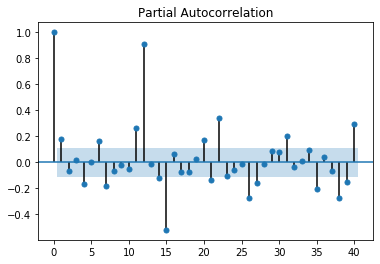

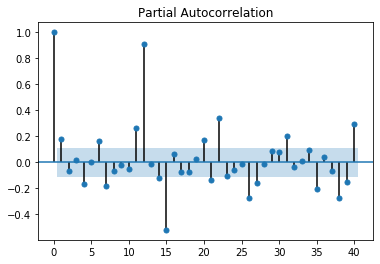

In [134]:
# теперь разберемся с параметрами p, P
# здесь видно, что последний значимый несезонный лаг равен одному (третий лаг внизу уже достиг порога значимости)
# а последний значимый сезонный лаг равен 1 (на самом деле если построить график дальше,
# то там будут еще сезонные лаги, но незначительно превышающие порог значимости лаги большого порядка обычно
# игнорируются)
# итак, p = 1, P = 1
plot_pacf(ts_flat, lags=40)

In [135]:
# теперь попробуем построить SARIMA с этими параметрами

In [136]:
from statsmodels.tsa.statespace import sarimax

In [137]:
model = sarimax.SARIMAX(ts, order=(1, 1, 2), seasonal_order=(1, 1, 3, 12))

In [138]:
res = model.fit()

In [139]:
preds = res.forecast(30)

In [140]:
plotting.plot_multiple_ts(ts, preds)

In [141]:
# Видим что получилось весьма неплохо!

In [142]:
# дальнейший подбор гиперпараметров можно осуществить используя критерий Акаике